CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [3]:
! pip install pandas
! pip install numpy
! pip install librosa
! pip install torch
! pip install matplotlib
! pip install tqdm

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 4.4 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.9 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)


In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset, DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed, split_dataset, preprocess_dataset, EarlyStopper, extract_features, generate_folds, MLP_hidden

# setting seed
set_seed(42)

Define the model class.

In [352]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout_prob=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc4(x))
        return x

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [353]:
data = pd.read_csv('audio_gtzan.csv')

# binary labels
def extract_label(filename):
    if 'blues' in filename:
        return 'blues'
    elif 'metal' in filename:
        return 'metal'
    else:
        raise ValueError(f"Unknown genre in filename: {filename}")

data['label'] = data['filename'].apply(extract_label)

X_train, y_train, X_test, y_test = split_dataset(
    data,
    columns_to_drop=['filename', 'label'],
    test_size=0.3,
    random_state=42
)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [354]:
class MusicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
train_dataset = MusicDataset(X_train_scaled, y_train)
test_dataset = MusicDataset(X_test_scaled, y_test)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2. Next, define the model, optimizer and loss function.

In [355]:
input_size = X_train_scaled.shape[1]
model = MLP(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [356]:

def train_epoch(model, dataloader, optimizer, loss_fn, device='cpu'):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, loss_fn, device='cpu'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
            total_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
early_stopper = EarlyStopper(patience=3)

n_epochs = 100
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    if early_stopper.early_stop(test_loss):
        print(f'Early stopping at epoch {epoch+1}')
        break

Epoch 1/100, Train Loss: 0.6694, Train Acc: 0.6836, Test Loss: 0.6047, Test Acc: 0.8233
Epoch 2/100, Train Loss: 0.5533, Train Acc: 0.8393, Test Loss: 0.4472, Test Acc: 0.8317
Epoch 3/100, Train Loss: 0.3958, Train Acc: 0.8507, Test Loss: 0.3448, Test Acc: 0.8500
Epoch 4/100, Train Loss: 0.3059, Train Acc: 0.8686, Test Loss: 0.2967, Test Acc: 0.8900
Epoch 5/100, Train Loss: 0.2374, Train Acc: 0.9043, Test Loss: 0.2410, Test Acc: 0.9183
Epoch 6/100, Train Loss: 0.1681, Train Acc: 0.9364, Test Loss: 0.1977, Test Acc: 0.9217
Epoch 7/100, Train Loss: 0.1393, Train Acc: 0.9507, Test Loss: 0.1864, Test Acc: 0.9333
Epoch 8/100, Train Loss: 0.1172, Train Acc: 0.9557, Test Loss: 0.1797, Test Acc: 0.9317
Epoch 9/100, Train Loss: 0.1053, Train Acc: 0.9607, Test Loss: 0.1781, Test Acc: 0.9383
Epoch 10/100, Train Loss: 0.0830, Train Acc: 0.9707, Test Loss: 0.1595, Test Acc: 0.9433
Epoch 11/100, Train Loss: 0.0775, Train Acc: 0.9750, Test Loss: 0.1472, Test Acc: 0.9483
Epoch 12/100, Train Loss: 0.06

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

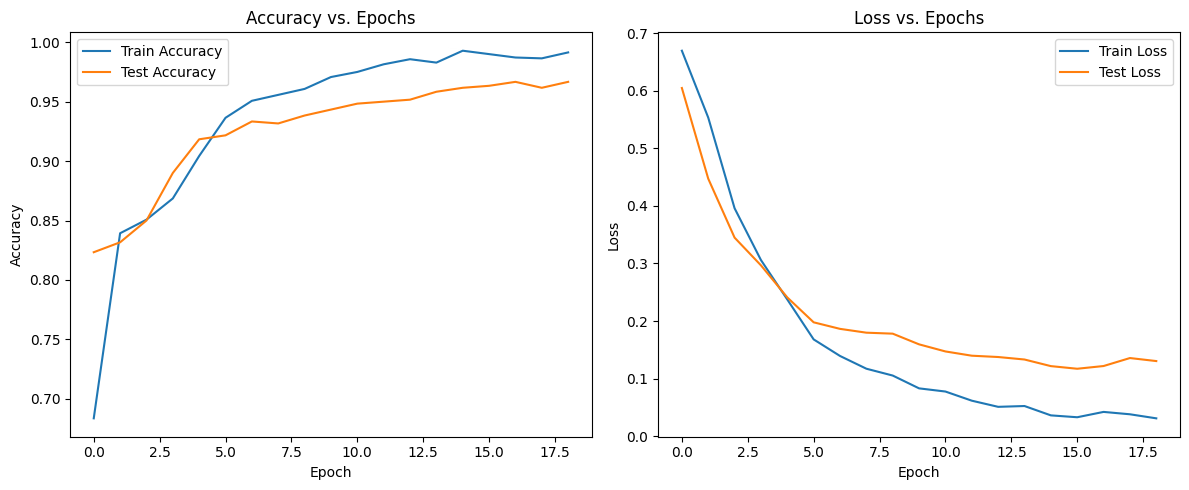

In [357]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.tight_layout()
plt.savefig('accuracy_loss_plots.png')
plt.show()

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [358]:
from common_utils import MLP_Custom

batch_sizes = [128, 256, 512, 1024]

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [359]:
df_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

n_folds = 5
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_folds(n_folds, batch_sizes, df_train_scaled, y_train)


2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [360]:
def batch_size_cv( X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, n_folds, learning_rate=0.001, n_epochs=100, device='cpu'):
    
    mean_accuracies = {bs: 0 for bs in batch_sizes}
    mean_times = {bs: 0 for bs in batch_sizes}
    
    for batch_size in batch_sizes:
        print(f'Testing Batch Size: {batch_size}')
        cv_accuracies = []
        epoch_times = []
        
        for fold in range(n_folds):
            print(f'  Fold: {fold+1}/{n_folds}')
            
            X_train_fold = X_train_scaled_dict[batch_size][fold]
            X_val_fold = X_val_scaled_dict[batch_size][fold]
            y_train_fold = y_train_dict[batch_size][fold]
            y_val_fold = y_val_dict[batch_size][fold]
            
            train_dataset = MusicDataset(X_train_fold, y_train_fold)
            val_dataset = MusicDataset(X_val_fold, y_val_fold)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            input_size = X_train_fold.shape[1]
            model = MLP_Custom(input_size=input_size, first_hidden_size=128)
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            loss_fn = nn.BCELoss()
            
            last_epoch_time = 0
            
            for epoch in range(n_epochs):
                if epoch == n_epochs - 1:
                    start_time = time.time()
                
                _, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
                
                if epoch == n_epochs - 1:
                    last_epoch_time = time.time() - start_time
                    
                    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
                    print(f'    Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
                    
                    cv_accuracies.append(val_acc)
                    epoch_times.append(last_epoch_time)
                else:
                    _, _ = evaluate(model, val_loader, loss_fn, device)
            
        mean_accuracies[batch_size] = np.mean(cv_accuracies)
        mean_times[batch_size] = np.mean(epoch_times)
        print(f'Mean accuracy: {mean_accuracies[batch_size]:.4f}, Mean epoch time: {mean_times[batch_size]:.4f}s')
    return mean_accuracies, mean_times

mean_cv_accuracies, mean_cv_times = batch_size_cv(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, n_folds, learning_rate=0.001, n_epochs=100, device='cpu')

Testing Batch Size: 128
  Fold: 1/5
    Train Acc: 1.0000, Val Loss: 0.1936, Val Acc: 0.9857
  Fold: 2/5
    Train Acc: 1.0000, Val Loss: 0.1644, Val Acc: 0.9786
  Fold: 3/5
    Train Acc: 1.0000, Val Loss: 0.0318, Val Acc: 0.9893
  Fold: 4/5
    Train Acc: 1.0000, Val Loss: 0.0902, Val Acc: 0.9893
  Fold: 5/5
    Train Acc: 1.0000, Val Loss: 0.0726, Val Acc: 0.9857
Mean accuracy: 0.9857, Mean epoch time: 0.0101s
Testing Batch Size: 256
  Fold: 1/5
    Train Acc: 1.0000, Val Loss: 0.0425, Val Acc: 0.9929
  Fold: 2/5
    Train Acc: 0.9973, Val Loss: 0.2108, Val Acc: 0.9679
  Fold: 3/5
    Train Acc: 0.9982, Val Loss: 0.0161, Val Acc: 0.9929
  Fold: 4/5
    Train Acc: 1.0000, Val Loss: 0.4070, Val Acc: 0.9893
  Fold: 5/5
    Train Acc: 0.9982, Val Loss: 0.0735, Val Acc: 0.9893
Mean accuracy: 0.9864, Mean epoch time: 0.0071s
Testing Batch Size: 512
  Fold: 1/5
    Train Acc: 0.9991, Val Loss: 0.0392, Val Acc: 0.9893
  Fold: 2/5
    Train Acc: 0.9982, Val Loss: 0.1629, Val Acc: 0.9643
  Fo

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

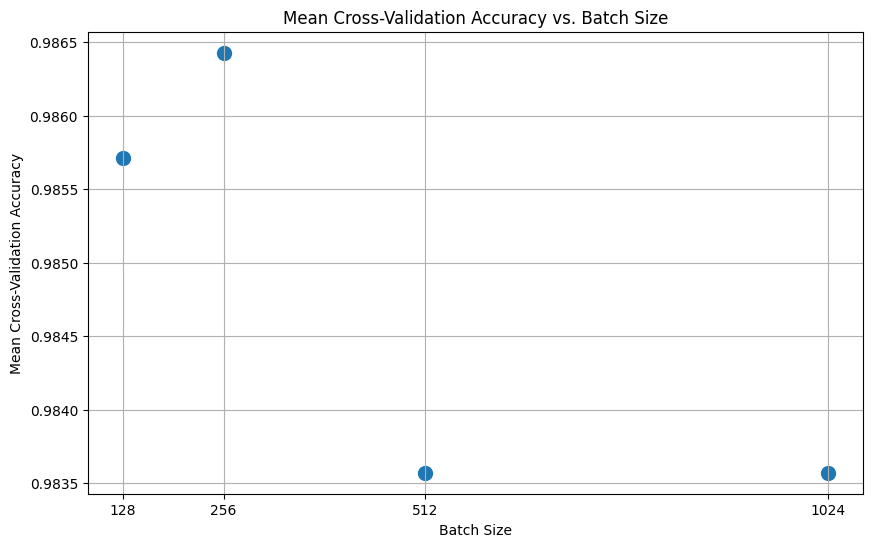

In [361]:
plt.figure(figsize=(10, 6))
plt.scatter(batch_sizes, [mean_cv_accuracies[bs] for bs in batch_sizes], marker='o', s=100)
plt.xticks(batch_sizes)
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy vs. Batch Size')
plt.grid(True)
plt.savefig('batch_size_accuracy.png')
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [362]:
time_df = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Mean Time per Epoch (seconds)': [mean_cv_times[bs] for bs in batch_sizes]
})
print("\nTime taken to train the network on the last epoch:")
print(time_df)


Time taken to train the network on the last epoch:
   Batch Size  Mean Time per Epoch (seconds)
0         128                       0.010093
1         256                       0.007119
2         512                       0.007281
3        1024                       0.006551


5. Select the optimal batch size and state a reason for your selection.

In [363]:
def score_batch_size(bs, acc_weight=0.8):
    max_acc = max(mean_cv_accuracies.values())
    min_acc = min(mean_cv_accuracies.values())
    acc_range = max_acc - min_acc
    norm_acc = (mean_cv_accuracies[bs] - min_acc) / acc_range if acc_range > 0 else 1
    
    max_time = max(mean_cv_times.values())
    min_time = min(mean_cv_times.values())
    time_range = max_time - min_time
    norm_time = 1 - ((mean_cv_times[bs] - min_time) / time_range if time_range > 0 else 0)
    
    return acc_weight * norm_acc + (1 - acc_weight) * norm_time

scores = {bs: score_batch_size(bs) for bs in batch_sizes}
optimal_batch_size = max(scores, key=scores.get)

print(f"\nOptimal batch size: {optimal_batch_size}")
print(f"Optimal batch size accuracy: {mean_cv_accuracies[optimal_batch_size]:.4f}")
print(f"Optimal batch size time per epoch: {mean_cv_times[optimal_batch_size]:.4f} seconds")


Optimal batch size: 256
Optimal batch size accuracy: 0.9864
Optimal batch size time per epoch: 0.0071 seconds


By normalizing both accuracy and training time to a 0-1 scale, the `score_batch_size` method enables comparison between different metrics, preventing either from dominating based solely on its scale. The selected weighting of 0.8 for accuracy reflects a practical priority: model performance is substantially more important than speed, but computational efficiency still matters, especially in resource-constrained environments. This balanced approach reveals batch size `256` as the optimal choice, scoring highest because it achieves the best accuracy (0.9864) while still maintaining reasonably efficient training times (0.00806 seconds per epoch). In contrast, smaller batches (128) sacrifice too much speed for marginal accuracy gains, while larger batches (512, 1024) achieve faster processing but at a significant cost to model performance.

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [364]:
neuron_sizes = [64, 128, 256]

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [365]:
def neuron_size_cv(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, 
                   neuron_sizes, batch_size, n_folds, learning_rate=0.001, 
                   n_epochs=100, device='cpu'):
    
    mean_validation_accuracies = {}
    
    for neurons in neuron_sizes:
        print(f'Testing neuron size: {neurons}')
        cv_accuracies = []
        
        for fold in range(n_folds):
            print(f'  Fold: {fold+1}/{n_folds}')
            
            X_train_fold = X_train_scaled_dict[neurons][fold]
            X_val_fold = X_val_scaled_dict[neurons][fold]
            y_train_fold = y_train_dict[neurons][fold]
            y_val_fold = y_val_dict[neurons][fold]
            
            train_dataset = MusicDataset(X_train_fold, y_train_fold)
            val_dataset = MusicDataset(X_val_fold, y_val_fold)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            input_size = X_train_fold.shape[1]
            model = MLP_hidden(no_features=input_size, no_neuron=neurons)
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            loss_fn = nn.BCELoss()
            
            for epoch in range(n_epochs):
                
                _, _ = train_epoch(model, train_loader, optimizer, loss_fn, device)
                if epoch < n_epochs - 1:
                    _, _ = evaluate(model, val_loader, loss_fn, device)

            _, val_acc = evaluate(model, val_loader, loss_fn, device)
            cv_accuracies.append(val_acc)
            
            print(f'    Final validation accuracy: {cv_accuracies[-1]:.4f}')
        
        mean_validation_accuracies[neurons] = np.mean(cv_accuracies)
        print(f'  Mean CV accuracy for {neurons} neurons: {mean_validation_accuracies[neurons]:.4f}')
    
    return mean_validation_accuracies

n_folds = 5
lr_rate = 0.001
n_epochs = 100
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_folds(n_folds=n_folds, parameters=neuron_sizes, training_features=df_train_scaled, training_labels=y_train)
mean_cv_accuracies = neuron_size_cv(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, neuron_sizes, optimal_batch_size, n_folds, learning_rate=lr_rate, n_epochs=n_epochs, device='cpu')

Testing neuron size: 64
  Fold: 1/5
    Final validation accuracy: 0.9929
  Fold: 2/5
    Final validation accuracy: 0.9679
  Fold: 3/5
    Final validation accuracy: 0.9929
  Fold: 4/5
    Final validation accuracy: 0.9786
  Fold: 5/5
    Final validation accuracy: 0.9857
  Mean CV accuracy for 64 neurons: 0.9836
Testing neuron size: 128
  Fold: 1/5
    Final validation accuracy: 0.9857
  Fold: 2/5
    Final validation accuracy: 0.9571
  Fold: 3/5
    Final validation accuracy: 0.9929
  Fold: 4/5
    Final validation accuracy: 0.9893
  Fold: 5/5
    Final validation accuracy: 0.9821
  Mean CV accuracy for 128 neurons: 0.9814
Testing neuron size: 256
  Fold: 1/5
    Final validation accuracy: 0.9857
  Fold: 2/5
    Final validation accuracy: 0.9607
  Fold: 3/5
    Final validation accuracy: 0.9929
  Fold: 4/5
    Final validation accuracy: 0.9857
  Fold: 5/5
    Final validation accuracy: 0.9821
  Mean CV accuracy for 256 neurons: 0.9814


2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

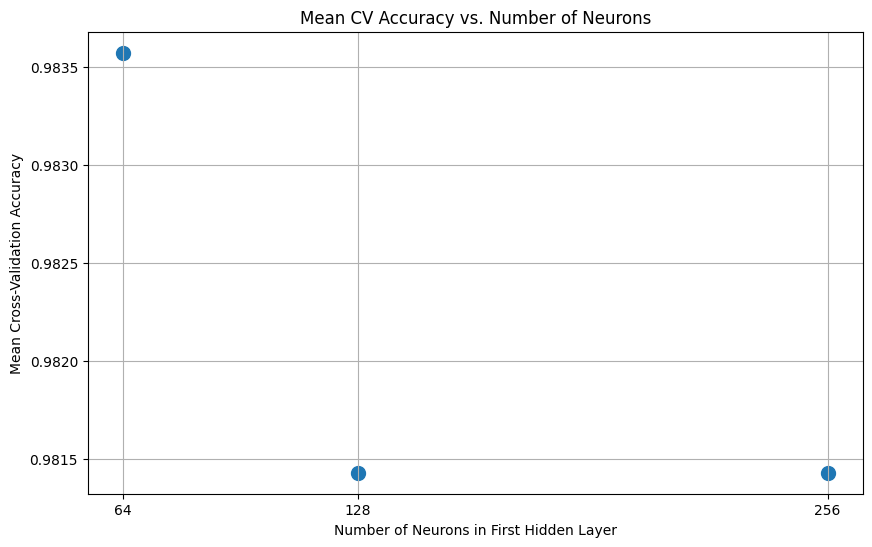

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(neuron_sizes, [mean_cv_accuracies[n] for n in neuron_sizes], marker='o', s=100)
plt.xlabel('Number of Neurons in First Hidden Layer')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean CV Accuracy vs. Number of Neurons')
plt.grid(True)
plt.xticks(neuron_sizes)
plt.savefig('neuron_size_accuracy.png')
plt.show()

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [367]:
optimal_neurons = max(mean_cv_accuracies, key=mean_cv_accuracies.get)

print(f"Optimal number of neurons: {optimal_neurons}")
print(f"Mean CV accuracy: {mean_cv_accuracies[optimal_neurons]:.4f}")

Optimal number of neurons: 64
Mean CV accuracy: 0.9836


In [368]:
print(X_train_scaled.shape[1])

57


The neural network with `64` neurons in the first hidden layer was selected because it achieved the highest mean cross-validation accuracy among the tested configurations. This indicates an optimal balance between:
1. Model capacity (enough neurons to capture patterns in the data)
2. Avoiding overfitting (not too many parameters that could memorize training data)
3. Computational efficiency (fewer neurons require less computation)

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

Epoch 1/100, Train Acc: 0.6636, Test Acc: 0.7950
Epoch 2/100, Train Acc: 0.8100, Test Acc: 0.8117
Epoch 3/100, Train Acc: 0.8257, Test Acc: 0.8133
Epoch 4/100, Train Acc: 0.8386, Test Acc: 0.8250
Epoch 5/100, Train Acc: 0.8564, Test Acc: 0.8533
Epoch 6/100, Train Acc: 0.8807, Test Acc: 0.8967
Epoch 7/100, Train Acc: 0.9186, Test Acc: 0.9133
Epoch 8/100, Train Acc: 0.9336, Test Acc: 0.9183
Epoch 9/100, Train Acc: 0.9500, Test Acc: 0.9267
Epoch 10/100, Train Acc: 0.9579, Test Acc: 0.9267
Epoch 11/100, Train Acc: 0.9600, Test Acc: 0.9317
Epoch 12/100, Train Acc: 0.9693, Test Acc: 0.9433
Epoch 13/100, Train Acc: 0.9700, Test Acc: 0.9450
Epoch 14/100, Train Acc: 0.9721, Test Acc: 0.9500
Epoch 15/100, Train Acc: 0.9786, Test Acc: 0.9567
Epoch 16/100, Train Acc: 0.9829, Test Acc: 0.9533
Epoch 17/100, Train Acc: 0.9829, Test Acc: 0.9567
Epoch 18/100, Train Acc: 0.9871, Test Acc: 0.9617
Epoch 19/100, Train Acc: 0.9921, Test Acc: 0.9583
Epoch 20/100, Train Acc: 0.9893, Test Acc: 0.9617
Epoch 21/

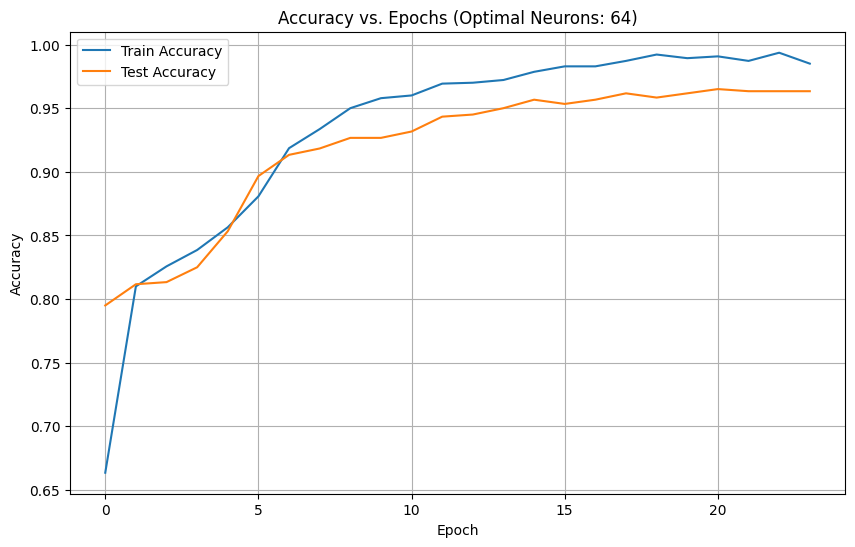

In [ ]:
input_size = X_train_scaled.shape[1]
final_model = MLP_hidden(no_features=input_size, no_neuron=optimal_neurons)
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

train_dataset = MusicDataset(X_train_scaled, y_train)
test_dataset = MusicDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=optimal_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=optimal_batch_size, shuffle=False)

train_accuracies = []
test_accuracies = []
n_epochs = 100
early_stopper = EarlyStopper(patience=3)

for epoch in range(n_epochs):
    _, train_acc = train_epoch(final_model, train_loader, optimizer, loss_fn)
    train_accuracies.append(train_acc)
    
    _, test_acc = evaluate(final_model, test_loader, loss_fn)
    test_accuracies.append(test_acc)
    
    print(f'Epoch {epoch+1}/{n_epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    if early_stopper.early_stop(1 - test_acc):
        print(f'Early stopping at epoch {epoch+1}')
        break

plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs. Epochs (Optimal Neurons: {optimal_neurons})')
plt.legend()
plt.grid(True)
plt.savefig('optimal_neuron_learning_curves.png')
plt.show()

torch.save(final_model.state_dict(), 'optimal_model.pth')

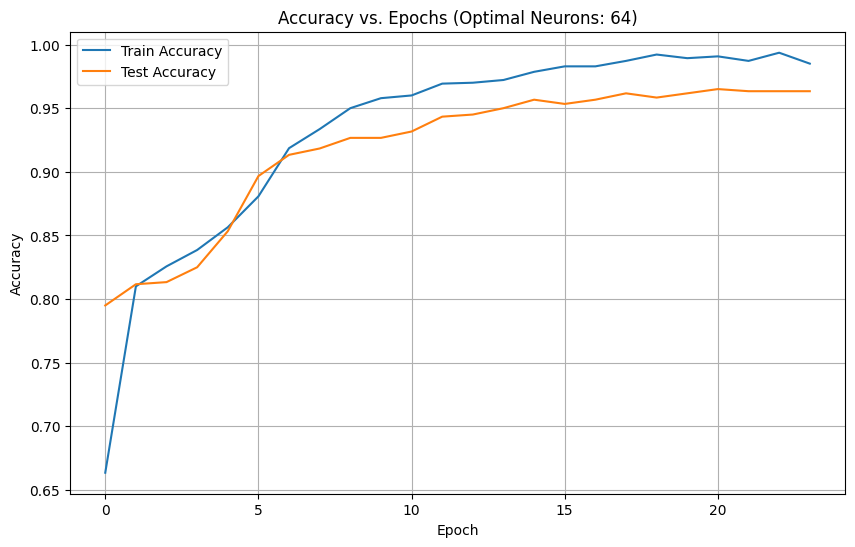

In [370]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs. Epochs (Optimal Neurons: {optimal_neurons})')
plt.legend()
plt.grid(True)
plt.savefig('optimal_neuron_learning_curves.png')
plt.show()

torch.save(final_model.state_dict(), 'optimal_model.pth')

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

> Install and import shap

In [44]:
! pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.2/532.2 kB 7.9 MB/s eta 0:00:00


> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [372]:
import IPython

# Load and preprocess the test audio file
test_audio_path = './audio_test.wav'
IPython.display.Audio(test_audio_path)

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [373]:
from common_utils import extract_features
df = extract_features(test_audio_path)

size_row, size_column = df.shape
print(f"DataFrame shape: {size_row} rows x {size_column} columns")
print(df.head())

DataFrame shape: 1 rows x 58 columns
           filename  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  ./audio_test.wav          0.431877         0.080057  0.056604  0.000293   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1191.619716           40957.603068              1726.917471   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0            38831.324373   2794.225223  ...    -3.746181   56.647854   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -6.391425   37.167595    -2.303412   43.675926    -8.247708    30.50214   

   mfcc20_mean  mfcc20_var  
0   -13.786491   46.941544  

[1 rows x 58 columns]


In [374]:
X_test_single = df.drop(['filename'], axis=1)
X_test_single = X_test_single[X_train.columns]

scaler = preprocessing.StandardScaler().fit(X_train)

X_test_single_scaled = scaler.transform(X_test_single)
X_test_single_scaled = X_test_single_scaled.flatten()

X_test_tensor = torch.tensor(X_test_single_scaled, dtype=torch.float32)
X_test_tensor = X_test_tensor.unsqueeze(0)
print(X_test_tensor.shape)

torch.Size([1, 57])


2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [375]:
input_size = X_train_scaled.shape[1]
print(input_size)
best_batch_size = optimal_batch_size
best_n_neurons = optimal_neurons

model = MLP_hidden(no_features=input_size, no_neuron=best_n_neurons)
model.load_state_dict(torch.load('optimal_model.pth'))
model.eval()

with torch.no_grad():
    output = model(X_test_tensor)
    pred_prob = output.item()
    pred_label = 1 if pred_prob >= 0.5 else 0

genre_map = {0: 'blues', 1: 'metal'}
predicted_genre = genre_map[pred_label]

print(f"Predicted probability: {pred_prob:.4f}")
print(f"Predicted label: {pred_label} ({predicted_genre})")

57
Predicted probability: 0.0001
Predicted label: 0 (blues)


> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [376]:
background_data = X_train_scaled[:100]
background_tensor = torch.tensor(background_data, dtype=torch.float32)

print(background_tensor.shape)
print(X_test_tensor.shape)

explainer = shap.DeepExplainer(model, background_tensor)

shap_values = explainer.shap_values(X_test_tensor)

feature_names = X_test_single.columns.tolist()

torch.Size([100, 57])
torch.Size([1, 57])


<Figure size 2000x300 with 0 Axes>

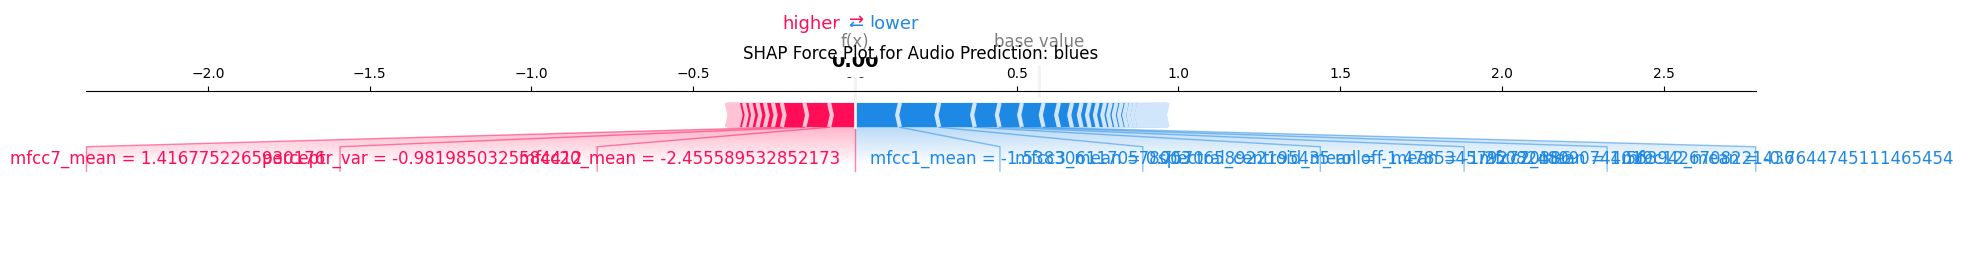

/var/folders/lm/rqsmrp091ssch6hl2_m2n0h80000gn/T/ipykernel_34211/705611063.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/Users/aryansethi/Documents/Personal/Neural-Networks-Assignment-1/.venv/lib/python3.10/site-packages/shap/plots/_beeswarm.py:718: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 1000x600 with 0 Axes>

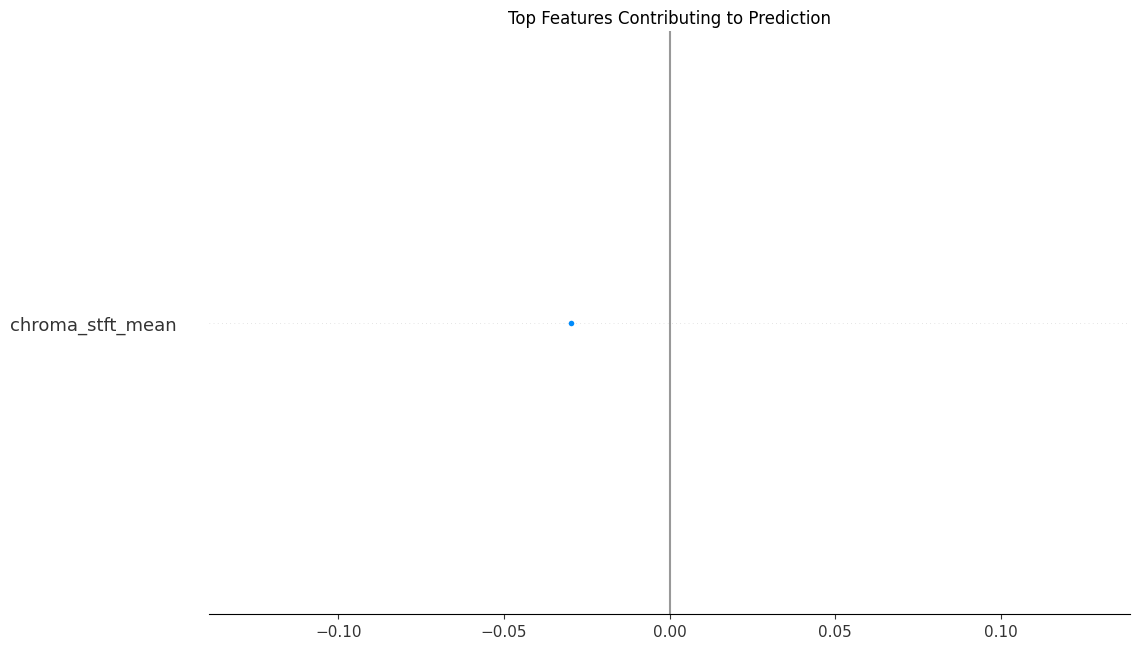

In [ ]:
plt.figure(figsize=(20, 3))
force_plot = shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][:, 0],       
    X_test_tensor.numpy(),      
    feature_names=feature_names,
    matplotlib=True,
    show=False
)

plt.title(f'SHAP Force Plot for Audio Prediction: {predicted_genre}')
plt.tight_layout()
plt.savefig('shap_force_plot.png')
plt.show()

# Top features
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test_tensor.numpy(),
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
plt.title('Top Features Contributing to Prediction')
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
plt.show()

In [400]:
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values[0][:, 0]).mean(axis=0)
})

top_features = feature_importance.sort_values('importance', ascending=False).head(5)

shap_df = pd.DataFrame(shap_values[0], columns=feature_names)

print("\nTop 5 most important features:")
print(top_features)

top_5_features = shap_df.abs().mean().sort_values(ascending=False).head(5)
for feature, importance in top_5_features.items():
    direction = "increased" if shap_df[feature].iloc[0] > 0 else "decreased"
    print(f"- {feature}: This feature {direction} the prediction probability by {abs(shap_df[feature].iloc[0]):.4f}")


Top 5 most important features:
             feature  importance
0   chroma_stft_mean     0.02389
29        mfcc7_mean     0.02389
31        mfcc8_mean     0.02389
32         mfcc8_var     0.02389
33        mfcc9_mean     0.02389
- mfcc1_mean: This feature decreased the prediction probability by 0.1390
- mfcc3_mean: This feature decreased the prediction probability by 0.1214
- spectral_centroid_mean: This feature decreased the prediction probability by 0.1101
- mfcc20_mean: This feature increased the prediction probability by 0.0799
- rolloff_mean: This feature decreased the prediction probability by 0.0765


The model predicted the audio sample as 'blues' with a probability of 0.0001.

The most important features for this prediction were:
- mfcc1_mean: This feature decreased the prediction probability by 0.1390
- mfcc3_mean: This feature decreased the prediction probability by 0.1214
- spectral_centroid_mean: This feature decreased the prediction probability by 0.1101
- mfcc20_mean: This feature increased the prediction probability by 0.0799
- rolloff_mean: This feature decreased the prediction probability by 0.0765

Analysis:
The SHAP force plot shows how each feature pushed the model output from the base value
toward the final prediction. Features pushing to the right (red) increased the prediction
toward 'metal', while features pushing to the left (blue) decreased it toward 'blues'.

This type of analysis helps us understand which audio characteristics are most distinctive
between blues and metal genres, providing valuable insights for audio classification tasks.